In [40]:
import math
import time
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import numpy as np
from tqdm import tqdm
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Comes from data preprocessing
bptt = 256

In [3]:
def load_data(path):
    x = torch.load(path+'_x.pt')
    y = torch.load(path+'_y.pt')
    lens = torch.load(path+'_lens.pt')

    idx = torch.cat([torch.tensor([0]), torch.cumsum(lens, 0)])

    y = [y[idx[i]:idx[i+1]].to(device) for i in range(len(idx)-1)]

    return x.to(device), y

In [4]:
X_train, Y_train = load_data("data/preprocessed/100k/train")
X_valid, Y_valid = load_data("data/preprocessed/100k/valid")
X_test, Y_test = load_data("data/preprocessed/100k/test")

In [5]:
bs = 32

# Precompute Y_batches given bs
Y_batches = []
for i in range(0, len(Y_train), bs):
    Y_batches.append(torch.cat(Y_train[i:i+bs], axis=0))

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [7]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, activation=nn.LeakyReLU())
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.head = nn.Linear(d_model, 8*8*13)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # self.linear.bias.data.zero_()
        # self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)

        output = self.transformer_encoder(src, src_mask)

        output = self.head(output)
        return output.reshape(*output.shape[:-1], 8, 8, 13)

In [8]:
with open("data/preprocessed/100k/vocab.pkl", "rb") as f:
    vocab, itos, stoi = pickle.load(f)

In [9]:
ntokens = len(vocab)  # size of vocabulary
emsize = 256  # embedding dimension
d_hid = 256  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 4  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [10]:
print(sum(torch.prod(torch.tensor(p.shape)) for p in model.parameters()))

tensor(1804864)


In [11]:
criterion = nn.CrossEntropyLoss()

# ONLY WAY I COULD GET IT TO WORK WAS FREEZING TRANSFORMER 
# AND ONLY TRAINING LAST LAYER AND THEN UNFREEZING WHOLE MODEL

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [12]:
print(stoi[" "])

4


In [13]:
print(X_train[0])

tensor([27, 10, 23, 14,  4, 23, 12,  4,  3, 10, 30, 14,  4,  2, 12,  4, 20, 10,
        11,  9,  4, 19,  2, 13,  4,  9, 10, 24, 28,  9,  4, 24, 15, 12,  4, 14,
        10, 19,  0, 15, 12,  4,  8,  0, 15, 12,  4, 22, 10, 19, 23, 20,  4, 25,
         8, 22,  4, 12, 10, 19,  8, 14,  4, 15, 22,  4, 13, 10, 24,  6,  9,  4,
        25,  8, 12,  4, 26, 10, 24, 15, 14,  4, 25,  8, 22,  4,  1, 10, 19,  0,
        15, 22,  4, 25,  0, 15, 14,  4,  3, 27, 10, 25,  6,  9,  4,  5, 30, 26,
         4,  3,  3, 10, 25,  0,  6, 13,  4, 24, 28, 12,  4,  3, 20, 10, 25, 23,
        26, 18,  4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 

In [14]:
def train(model: nn.Module, optimizer, verbose=True):
    log = []

    total_loss = 0.
    total_p_acc = 0.
    total_b_acc = 0.
    start_time = time.time()

    for i in range(0, len(X_train), bs):
        batch = i//bs+1

        X_batch = X_train[i:i+bs]
        spaces = torch.where(X_batch == stoi[" "])
        
        Y_batch = Y_batches[i//bs]
        
        # Fucking kill me.  Torch expects bptt dim first instead of batch
        output = torch.swapaxes(model(X_batch.T), 0, 1)

        y_pred = output[spaces[0], spaces[1]]

        # print(y_pred.shape, Y_batch.shape)
        # assert False

        loss = criterion(y_pred.view(-1, 13), Y_batch.view(-1))

        equal = (y_pred.argmax(-1) == Y_batch)

        piece_acc = equal.float().mean().item()
        board_acc = equal.all(-1).all(-1).float().mean().item()


        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_p_acc += piece_acc
        total_b_acc += board_acc

        ms_per_batch = (time.time() - start_time) * 1000 / batch
        cur_loss = total_loss / batch
        cur_p_acc = total_p_acc / batch
        cur_b_acc = total_b_acc / batch

        if verbose:
            print(f'| {batch:5d}/{len(X_train)//bs+1:5d} batches | '
                    f'ms/batch {ms_per_batch:5.2f} | '
                    f'loss {cur_loss:5.2f} | piece acc {cur_p_acc:5.2f} | board acc {cur_b_acc:5.2f} ', end="\r")
        
        log.append({"loss":loss.item(), "piece_acc":piece_acc, "board_acc":board_acc})

    if verbose:
        print()

    return log

In [ ]:
# Optimization schedule:
# Train head with lr=1e-2 for 1 epcoh
# Train full model with lr=1e-3 for ~7 epcoh
# Train full model with lr=1e-4 for 2 epcoh

In [102]:
epochs = 1_000
model.train()  # turn on train mode

# bar = tqdm(range(epochs))
bar = range(epochs)

log = []

# optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-2)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for e in bar:
    # After first epoch switch to full model
    # if e == 1:
    #     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    l = train(model, verbose=True)
    log = log + l


    # bar.set_postfix(l[-1])

|  2844/ 2844 batches | ms/batch 35.32 | loss  0.00 | piece acc  1.00 | board acc  0.96  
|  2844/ 2844 batches | ms/batch 35.58 | loss  0.00 | piece acc  1.00 | board acc  0.98 


KeyboardInterrupt: 

In [103]:
# Precompute Y_batches given bs
Y_batches_val = []
for i in range(0, len(Y_valid), bs):
    Y_batches_val.append(torch.cat(Y_valid[i:i+bs], axis=0))

In [104]:
@torch.no_grad()
def valid(model: nn.Module, verbose=True):

    total_loss = 0.
    total_p_acc = 0.
    total_b_acc = 0.
    start_time = time.time()
    
    scores = []

    for i in range(0, len(X_valid), bs):
        batch = i//bs+1

        X_batch = X_valid[i:i+bs]
        spaces = torch.where(X_batch == stoi[" "])
        
        Y_batch = Y_batches_val[i//bs]
        
        # Fucking kill me.  Torch expects bptt dim first instead of batch
        output = torch.swapaxes(model(X_batch.T), 0, 1)

        y_pred = output[spaces[0], spaces[1]]
        
        scores.append(y_pred)

        loss = criterion(y_pred.view(-1, 13), Y_batch.view(-1))

        equal = (y_pred.argmax(-1) == Y_batch)

        piece_acc = equal.float().mean().item()
        board_acc = equal.all(-1).all(-1).float().mean().item()

        total_loss += loss.item()
        total_p_acc += piece_acc
        total_b_acc += board_acc

        ms_per_batch = (time.time() - start_time) * 1000 / batch
        cur_loss = total_loss / batch
        cur_p_acc = total_p_acc / batch
        cur_b_acc = total_b_acc / batch

        if verbose:
            print(f'| {batch:5d}/{len(X_valid)//bs+1:5d} batches | '
                    f'ms/batch {ms_per_batch:5.2f} | '
                    f'loss {cur_loss:5.2f} | piece acc {cur_p_acc:5.2f} | board acc {cur_b_acc:5.2f} ', end="\r")

    if verbose:
        print()

    return scores, cur_p_acc, cur_b_acc

In [105]:
scores, p_acc, b_acc = valid(model)

|   474/  474 batches | ms/batch  8.09 | loss  0.00 | piece acc  1.00 | board acc  0.95  


In [106]:
print(p_acc, b_acc)

0.9991431414829528 0.954306012467493


In [107]:
print(scores[0].shape)
print(Y_batches_val[0].shape)

torch.Size([1418, 8, 8, 13])
torch.Size([1418, 8, 8])


In [108]:
print(np.mean([len(y) for y in Y_train]))

42.85260277585468


In [109]:
max_len = max(len(y) for y in Y_valid)

piece_accs = torch.zeros(max_len)
board_accs = torch.zeros(max_len)

n = torch.zeros(max_len)

earliest_mistake = [-1, 256]

with torch.no_grad():
    for i in tqdm(range(len(X_valid))):
        x = X_valid[i:i+1]
        y = Y_valid[i]

        spaces = torch.where(x == stoi[" "])
        
        # Fucking kill me.  Torch expects bptt dim first instead of batch
        output = torch.swapaxes(model(x.T), 0, 1)

        y_pred = output[spaces]

        loss = criterion(y_pred.view(-1, 13), y.view(-1))
        equal = (y_pred.argmax(-1) == y).cpu()

        for j, correct in enumerate(equal.all(-1).all(-1)):
            if not correct:
                if j < earliest_mistake[1]:
                    earliest_mistake = [i, j]

        moves = y.shape[0]
        n[:moves] += 1

        piece_accs[:moves] += equal.float().mean(-1).mean(-1)
        board_accs[:moves] += equal.all(-1).all(-1).float()

piece_accs /= n
board_accs /= n

  0%|          | 0/15166 [00:00<?, ?it/s]

100%|██████████| 15166/15166 [01:18<00:00, 193.80it/s]


In [110]:
print(earliest_mistake)

[10618, 8]


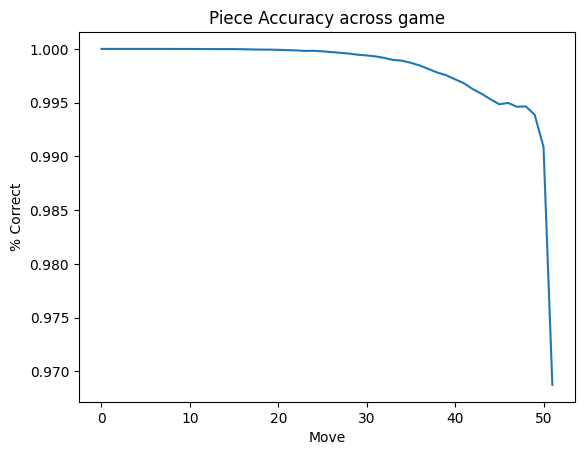

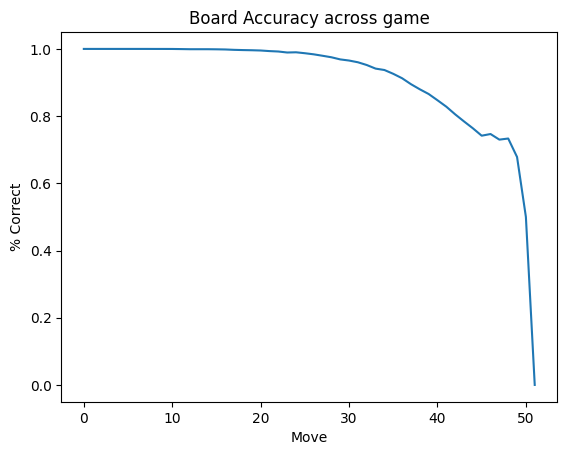

In [111]:
plt.title("Piece Accuracy across game")
plt.plot(piece_accs)
plt.xlabel("Move")
plt.ylabel("% Correct")
plt.show()

plt.title("Board Accuracy across game")
plt.plot(board_accs)
plt.xlabel("Move")
plt.ylabel("% Correct")
plt.show()

In [112]:
def char_encode(inp):
    if isinstance(inp, str):
        return torch.tensor([stoi[c] for c in inp])
    else:
        return [char_encode(line) for line in inp]

In [113]:
# example = "0.e4 e6 1.d4 b6 2.a3 Bb7 3.Nc3 Nh6 4.Bxh6 gxh6 5.Be2 Qg5 6.Bg4 h5 7.Nf3 Qg6 8.Nh4 Qg5 9.Bxh5 Qxh4 10.Qf3 Kd8 11.Qxf7 Nc6 12.Qe8# "
# Messes up here
example = "0.e3 b5 1.Bc4 a6 2.Bf1 "# Nh6 "
# example = "0.e3 b5 1.Bc4 a6 2.Kf1 Nh6 3.Ke1 Nf5 4.Bf1 "

In [114]:
inp = char_encode(example).unsqueeze(0).to(device)

# Earliest mistake at move 5 (idx 4)
# inp = X_valid[10460].unsqueeze(0)

output = torch.swapaxes(model(inp.T), 0, 1)

spaces = torch.where(inp == stoi[" "])
y_pred = output[spaces]

b = y_pred.argmax(-1)

In [115]:
piece_dict = {
    '.': 0, 'p': 1, 'n': 2, 'b': 3, 'k': 4, 'r': 5, 'q': 6, 'P': 7, 'N': 8, 'B': 9, 'K': 10, 'R': 11, 'Q': 12
}

dict_piece = {v:k for k, v in piece_dict.items()}

def tensor_to_ascii(tensor):
    arr = tensor.tolist()
    return "\n".join([" ".join([dict_piece[p] for p in row]) for row in arr])

In [116]:
print("".join([itos[c.item()] for c in X_valid[10460]]))

0.e4 c6 1.Bc4 d5 2.Bf1 dxe4 3.d4 exd3 4.cxd3 Nf6 5.Nc3 Bf5 6.g4 Bxg4 7.f3 Bh5 8.Qb3 Qb6 9.Bf4 Qxb3 10.axb3 Nbd7 11.Nd5 Nxd5 12.Nh3 e6 13.Rd1 Bb4+ 14.Ke2 O-O 15.Ng5 Nxf4+ 16.Ke3 Nd5+ 17.Ke4 N7f6+ 18.Ke5 Rad8 19.Rd2 Bd6+ 20.Kd4 a6 21.Bh3 c5+ 22.Kc4 b5# .....


In [117]:
for i in b:
    print(tensor_to_ascii(i))
    print()

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p . p p p p p p
. . . . . . . .
. p . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p . p p p p p p
. . . . . . . .
. p . . . . . .
. . B . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K . N R

r n b q k b n r
. . p p p p p p
p . . . . . . .
. p . . . . . .
. . B . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K . N R

r n b q k b n r
. . p p p p p p
p . . . . . . .
. p . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R



<BarContainer object of 13 artists>

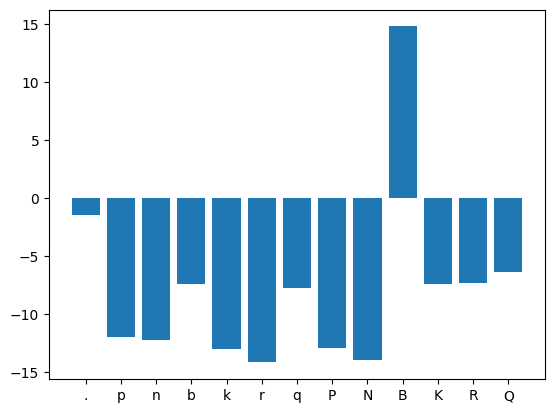

In [118]:
plt.bar(piece_dict.keys(), y_pred[-1, -1, 5].cpu().detach())